In [1]:
import pandas as pd
import numpy as np
import copy
import pickle
import os
import sys
from matplotlib import pyplot as plt
plt.rc('font', size=13)      
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_palette("PuBuGn_d")

sys.path.append("/home/alex/Dropbox/smc_hmc/python_smchmc/smc_sampler_functions/")
sys.path.append("/home/alex/Dropbox/smc_hmc/python_smchmc/")
sys.path.append("/home/alex/Dropbox/smc_hmc/python_smchmc/help/")
sys.path.append("/scratch/alexander/hsmc/smc_sampler_functions/")
sys.path.append("/scratch/alexander/hsmc/")
sys.path.append("/scratch/alexander/hsmc/help/")

import smc_sampler_functions.proposal_kernels
#path = os.getcwd()
#path = path.replace("/ipython_notebooks","")
#path = "/home/alex/inter_simulation_results/hsmc_harvard/results_simulation_normal"
#path = "/home/alex/Dropbox/smc_hmc/python_smchmc/results_simulation_normal"
#path = "/media/alex/Transcend/hsmc/results_simulation_normal"
path = "/media/alexander/Transcend/hsmc/results_simulation_normal/"


os.chdir(path)
names_files_list = os.listdir(path)
print(names_files_list)
#import getsize_function

['comp_load_normal_dim_10.pdf', 'comp_load_normal_dim_10.png', 'comp_load_normal_dim_100.pdf', 'comp_load_normal_dim_100.png', 'comp_load_normal_dim_20.pdf', 'comp_load_normal_dim_20.png', 'comp_load_normal_dim_200.pdf', 'comp_load_normal_dim_200.png', 'comp_load_normal_dim_300.pdf', 'comp_load_normal_dim_300.png', 'comp_load_normal_dim_400.pdf', 'comp_load_normal_dim_400.png', 'comp_load_normal_dim_50.pdf', 'comp_load_normal_dim_50.png', 'comp_load_normal_dim_500.pdf', 'comp_load_normal_dim_500.png', 'error_mean_normal_dim_10.pdf', 'error_mean_normal_dim_10.png', 'normalsampler_HMC_L_random_ft_non_adaptive_rep_4_dim_100.p', 'normalsampler_HMC_L_random_ft_non_adaptive_rep_4_dim_20.p', 'normalsampler_HMC_L_random_ft_non_adaptive_rep_4_dim_200.p', 'normalsampler_HMC_L_random_ft_non_adaptive_rep_4_dim_300.p', 'normalsampler_HMC_L_random_ft_non_adaptive_rep_4_dim_400.p', 'normalsampler_HMC_L_random_ft_non_adaptive_rep_4_dim_50.p', 'normalsampler_HMC_L_random_ft_non_adaptive_rep_4_dim_500.p

In [2]:
dim_list = [10, 20, 50, 100, 200, 300, 400, 500]
#dim_list = [10, 50, 200]
dim_len = len(dim_list)
M = 39
#names_samplers = ["normalsampler_HMC_L_random_ours_adaptive_", "normalsampler_HMC_L_random_ft_adaptive_", 
#        "normalsampler_HMC_L_random_ft_non_adaptive_", "normalsampler_HMC_L_random_ours_non_adaptive_",
#         "normalsampler_MALA_", "normalsampler_RW_"]
#ames_prop = ['HMCAO', 'HMCAFT', 'HMCNFT', 'HMCNO', 'MALA', 'RW']
names_prop = ['HMCAPR', 'HMCAFT', 'HMCNFT', 'MALA']
names_samplers = ["normalsampler_HMC_L_random_ours_adaptive_", "normalsampler_HMC_L_random_ft_adaptive_", 
        "normalsampler_HMC_L_random_ft_non_adaptive_", "normalsampler_MALA_"]


num_sampler = len(names_samplers)
norm_const = np.zeros((M, num_sampler, dim_len))
trace_mean_particles = np.zeros((M, num_sampler, dim_len))
comp1_mean_particles = np.zeros((M, num_sampler, dim_len))
trace_var_particles = np.zeros((M, num_sampler, dim_len))
computational_load = np.zeros((M, num_sampler, dim_len))
ESJD_array = np.zeros((M, num_sampler, dim_len))
epsilon_array = np.zeros((M, num_sampler, dim_len))
L_array = np.zeros((M, num_sampler, dim_len))
list_ess_temp = { str(dim): {name: [] for name in names_prop} for dim in dim_list}
list_ess_movesteps = { str(dim): {name: [] for name in names_prop} for dim in dim_list}

In [3]:
for i_dim, dim in enumerate(dim_list):
    for m_rep in range(M):
        for i, name_sampler in enumerate(names_samplers):
            name_to_load = name_sampler+"rep_%s_dim_%s.p"%(m_rep+1, dim)
            res_dict = pickle.load(open(name_to_load, 'rb'))
            norm_const[m_rep, i, i_dim] = (sum(res_dict['Z_list']))**2
            comp1_mean_particles[m_rep, i, i_dim] = np.linalg.norm(res_dict['particles_resampled'].mean(axis=0)[0]-res_dict['parameters']['targetmean'][0])**2
            trace_mean_particles[m_rep, i, i_dim] = np.linalg.norm(res_dict['particles_resampled'].mean(axis=0)-res_dict['parameters']['targetmean'])**2
            trace_var_particles[m_rep, i, i_dim] = np.linalg.norm(res_dict['particles_resampled'].var(axis=0)-np.diag(res_dict['parameters']['targetvariance']))**2
            ESJD_array[m_rep, i, i_dim] = res_dict['ESJD'][-1]
            if 'PR' in names_prop[i]:
                computational_load[m_rep, i, i_dim] = len(res_dict['temp_list'])* res_dict['L_mean'].mean()+(np.unique(res_dict['temp_list'])).shape[0]*res_dict['L_mean'].mean()
            else: 
                computational_load[m_rep, i, i_dim] = len(res_dict['temp_list'])* res_dict['L_mean'].mean()

            #computational_load[m_rep, i, i_dim] = len(res_dict['temp_list'])* res_dict['L_mean'].mean()
            epsilon_array[m_rep, i, i_dim] = res_dict['epsilon_mean'][-1]
            L_array[m_rep, i, i_dim] = res_dict['L_mean'][-1]
            
            # for plotting ESS vs temp
            dict_ess_temp = {'temp': np.unique(res_dict['temp_list']), 'ESS' : res_dict['ESS_list']}
            list_ess_temp[str(dim)][names_prop[i]].append(dict_ess_temp)
            # for plotting temp vs move steps
            unique, counts = np.unique(res_dict['temp_list'], return_counts=True)
            dict_ess_steps = {'temp': unique, 'steps' : counts}
            list_ess_movesteps[str(dim)][names_prop[i]].append(dict_ess_steps)

In [4]:
#res_dict['temp_list'], res_dict['L_mean'].mean()
#res_dict['temp_list']

from tabulate import tabulate 
print(tabulate(ESJD_array.mean(axis=0).transpose(), names_prop, tablefmt="latex", floatfmt=".2f"))

\begin{tabular}{rrrr}
\hline
   HMCAO &   HMCAFT &   HMCNFT &   MALA \\
\hline
   50.64 &    61.03 &    59.42 &   9.89 \\
   77.78 &   109.14 &   105.93 &  14.65 \\
  174.64 &   255.98 &   250.38 &  30.56 \\
  338.28 &   499.59 &   488.12 &  50.69 \\
  639.35 &   989.97 &   952.39 &  85.22 \\
  947.55 &  1409.44 &  1377.96 & 111.86 \\
 1259.64 &  1810.05 &  1758.40 & 135.43 \\
 1513.90 &  2180.85 &  2152.51 & 156.03 \\
\hline
\end{tabular}


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_palette("husl")
#sns.set_palette("PuBuGn_d")

#import matplotlib
#matplotlib.rcParams.update({'font.size': 22})
plt.rc('font', size=13)      




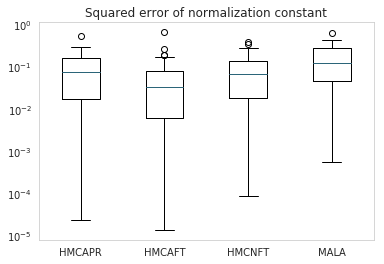

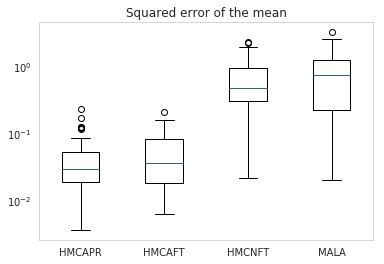

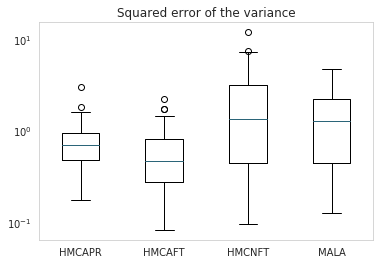

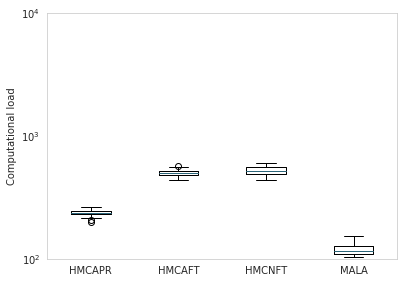

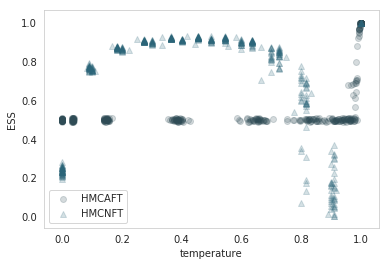

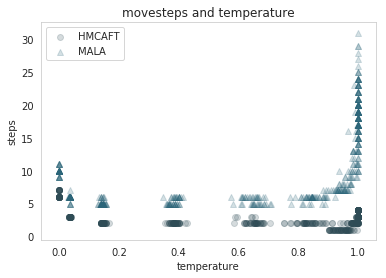

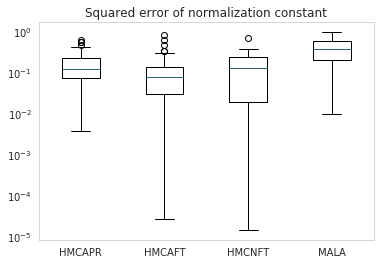

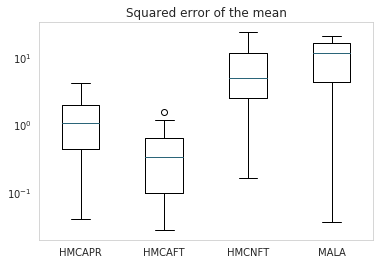

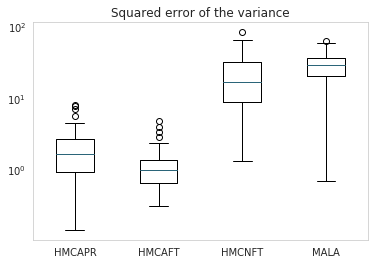

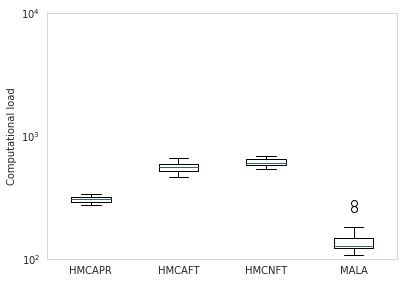

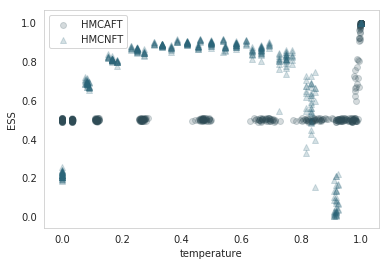

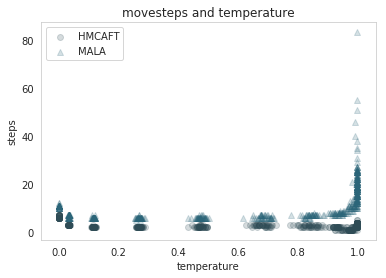

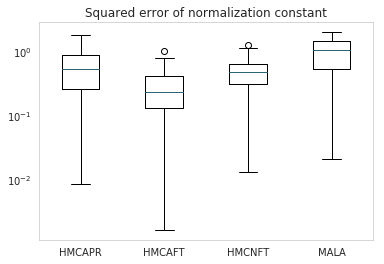

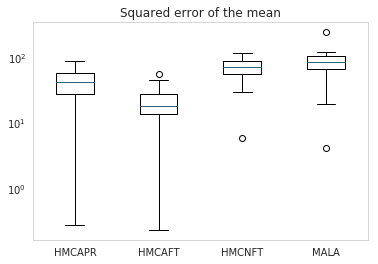

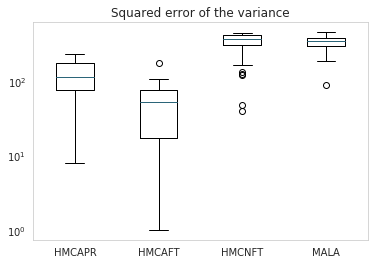

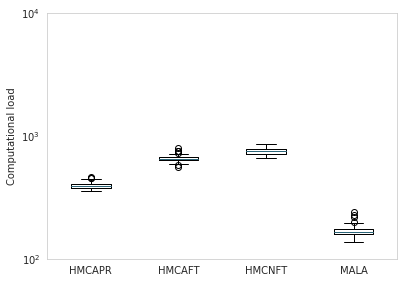

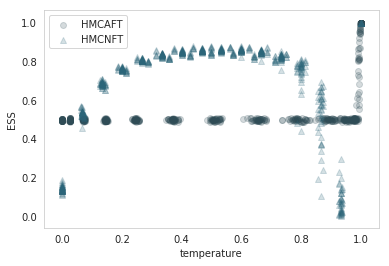

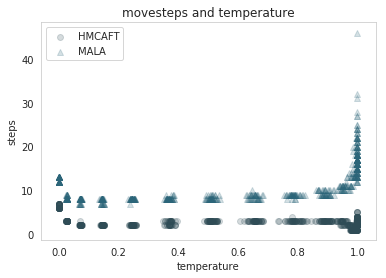

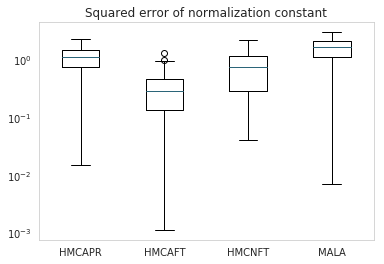

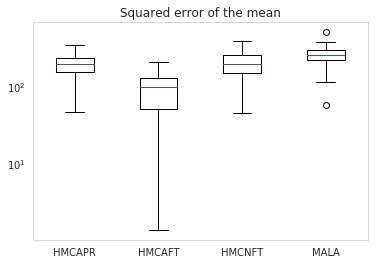

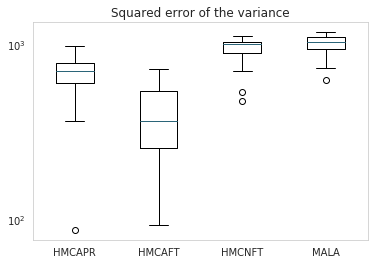

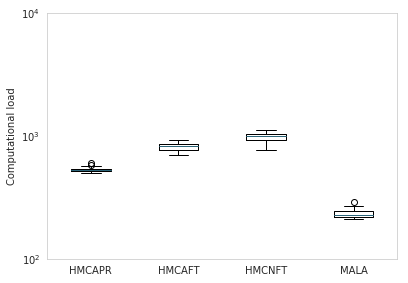

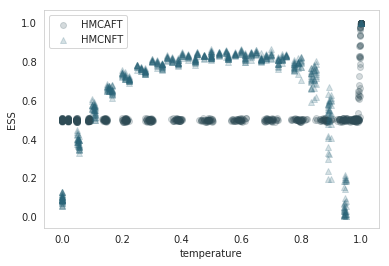

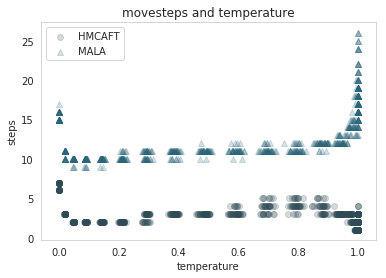

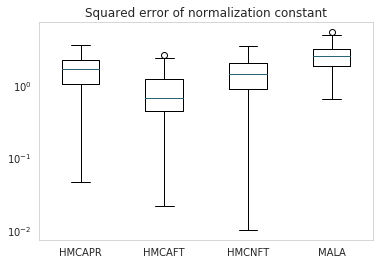

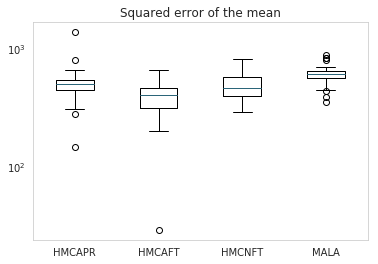

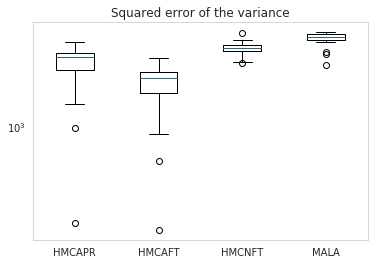

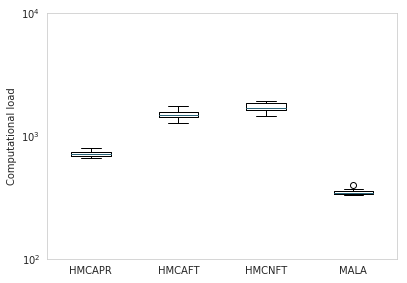

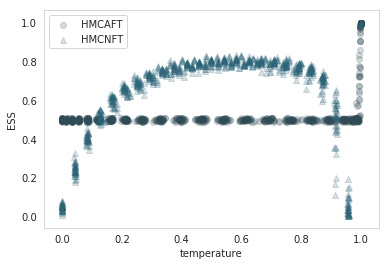

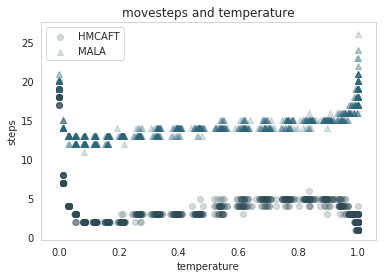

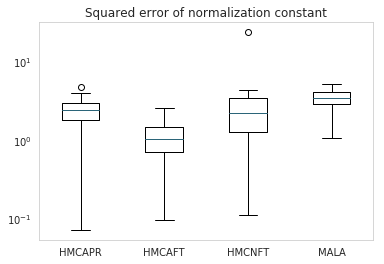

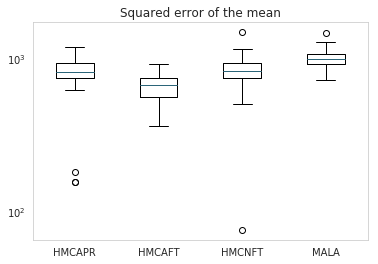

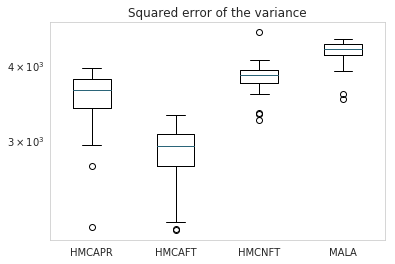

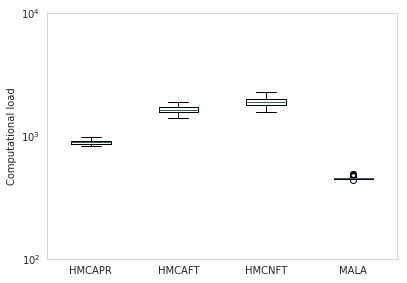

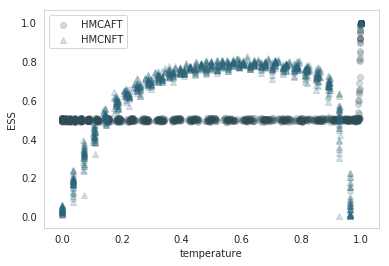

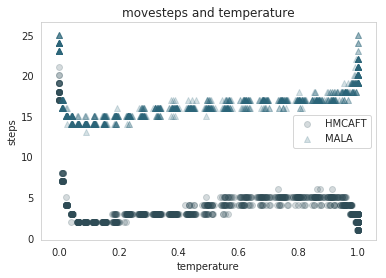

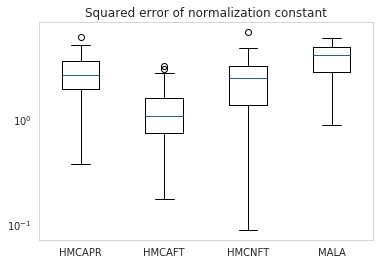

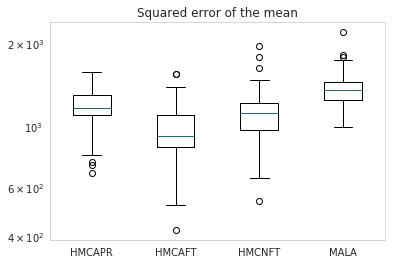

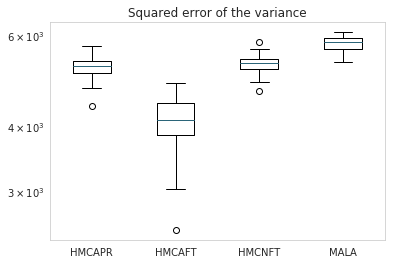

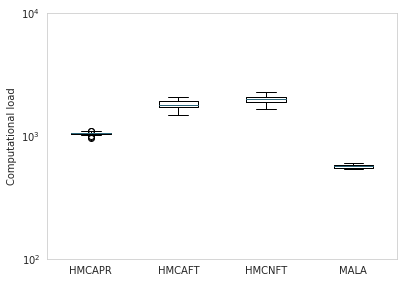

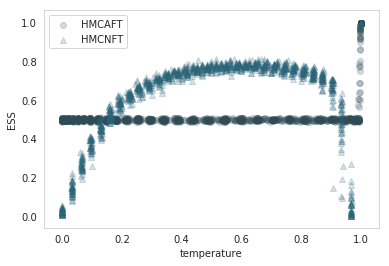

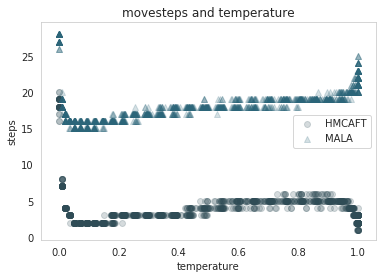

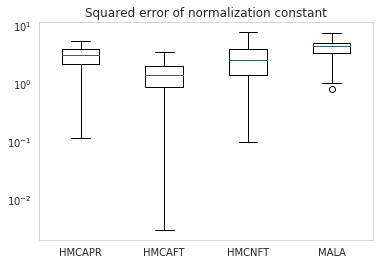

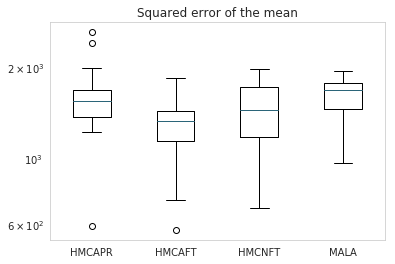

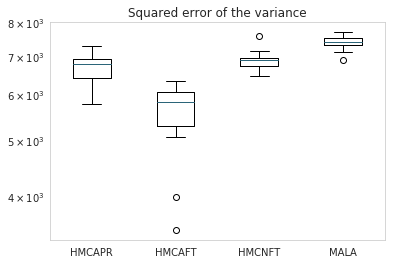

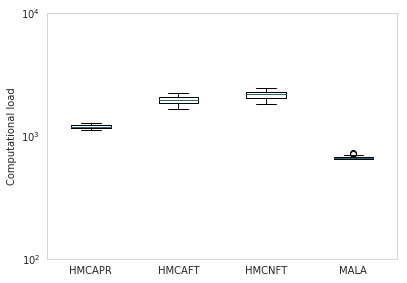

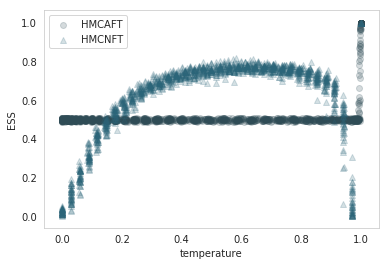

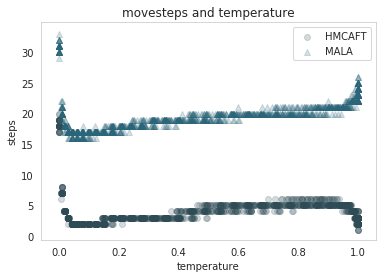

In [8]:
for i_dim, dim in enumerate(dim_list):
    plt.title('Squared error of normalization constant')
    plt.boxplot(norm_const[:,:,i_dim], labels=names_prop); plt.yscale('log')
    plt.savefig('norm_const_normal_dim_%s.pdf'%dim); plt.show()
    
    plt.title('Squared error of the mean')
    plt.boxplot(trace_mean_particles[:,:,i_dim], labels=names_prop); plt.yscale('log')
    plt.savefig('error_mean_normal_dim_%s.pdf'%dim); plt.show()
    
    plt.title('Squared error of the variance')
    plt.boxplot(trace_var_particles[:,:,i_dim], labels=names_prop); plt.yscale('log')
    plt.savefig('error_variance_normal_dim_%s.pdf'%dim); plt.show()

    #plt.title('Computational load')
    plt.boxplot(computational_load[:,:,i_dim], labels=names_prop); plt.yscale('log')
    plt.ylabel('Computational load')
    plt.tight_layout()
    plt.ylim(10**2, 10**4)
    plt.savefig('comp_load_normal_dim_%s.pdf'%dim); plt.show()

    for k, name in enumerate(['HMCAFT', 'HMCNFT']):
        list_frames = [pd.DataFrame(i) for i in list_ess_temp[str(dim)][name]]
        #reduce(lambda x, y: pd.concat(x, y), list_frames)
        res = pd.concat(list_frames)
        plt.scatter(x=res['temp'], y=res['ESS'], label=name, alpha=0.2, marker=['o', '^'][k])
    plt.legend()
    plt.ylabel('ESS'); plt.xlabel('temperature')
    #plt.title('ESS and temperature')
    plt.savefig('ESS_adaptation_normal_dim_%s.pdf'%dim); plt.show()
    
    for k, name in enumerate(['HMCAFT', 'MALA']):#, 'RW']:#, 'HMCNO']:
        list_frames = [pd.DataFrame(i) for i in list_ess_movesteps[str(dim)][name]]
        #reduce(lambda x, y: pd.concat(x, y), list_frames)
        res = pd.concat(list_frames)
        plt.scatter(x=res['temp'], y=res['steps'], label=name, alpha=0.2, marker=['o', '^'][k])
    plt.legend()
    plt.ylabel('steps'); plt.xlabel('temperature')
    plt.title('movesteps and temperature')
    plt.savefig('movesteps_adaptation_normal_dim_%s.pdf'%dim); plt.show()

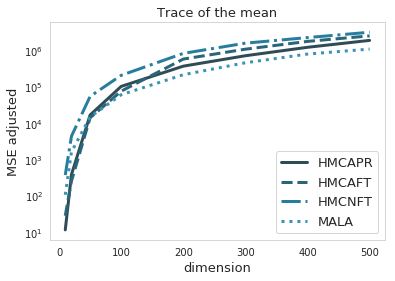

In [10]:
#linestyles = ['-', '--', '-', '--', '-.', ':']
linestyles = ['-', '--', '-.', ':']#, '-.', ':']

for i, style in enumerate(names_prop):
    plt.plot(dim_list, (trace_mean_particles.mean(axis=0)*computational_load.mean(axis=0)).transpose()[:,i], linestyle=linestyles[i], linewidth=3)
plt.ylabel('MSE adjusted', fontsize=13); plt.xlabel('dimension', fontsize=13)
plt.title('Trace of the mean', fontsize=13)
plt.legend(names_prop, fontsize=13, loc=0)
plt.yscale('log')
plt.savefig('normal_mse_comp_over_dim.pdf')
plt.show()


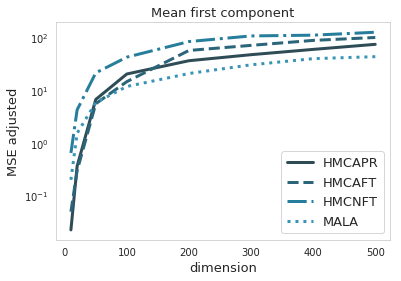

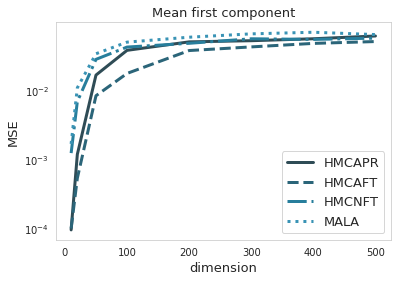

In [11]:

for i, style in enumerate(names_prop):
    plt.plot(dim_list, (comp1_mean_particles.mean(axis=0)*computational_load.mean(axis=0)).transpose()[:,i], linestyle=linestyles[i], linewidth=3)
plt.ylabel('MSE adjusted', fontsize=13); plt.xlabel('dimension', fontsize=13)
plt.title('Mean first component', fontsize=13)
plt.legend(names_prop, fontsize=13, loc=0)
plt.yscale('log')
plt.savefig('normal_mse_comp1_over_dim.pdf')
plt.show()


for i, style in enumerate(names_prop):
    plt.plot(dim_list, (comp1_mean_particles.mean(axis=0)).transpose()[:,i], linestyle=linestyles[i], linewidth=3)
plt.ylabel('MSE', fontsize=13); plt.xlabel('dimension', fontsize=13)
plt.title('Mean first component', fontsize=13)
plt.legend(names_prop, fontsize=13, loc=0)
plt.yscale('log')
plt.savefig('normal_mse_unadjusted_comp1_over_dim.pdf')
plt.show()

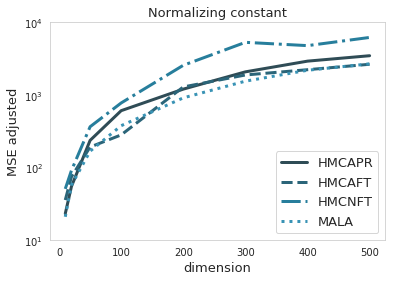

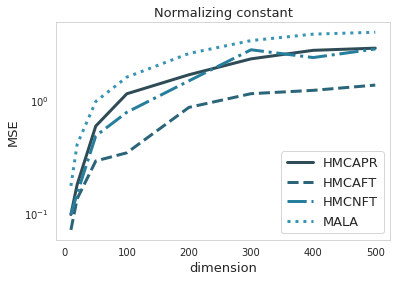

In [13]:
#linestyles = ['-', '--', '-', '--', '-.', ':']
for i, style in enumerate(names_prop):
    plt.plot(dim_list, (norm_const.mean(axis=0)*computational_load.mean(axis=0)).transpose()[:,i], linestyle=linestyles[i], linewidth=3)

plt.ylabel('MSE adjusted',fontsize=13); plt.xlabel('dimension',fontsize=13)
plt.title('Normalizing constant', fontsize=13)
plt.legend(names_prop, fontsize=13, loc=0)
plt.yscale('log'); plt.ylim(10,10**4)
plt.savefig('normal_mse_normconst_comp_over_dim.pdf')
plt.show()


for i, style in enumerate(names_prop):
    plt.plot(dim_list, (norm_const.mean(axis=0)).transpose()[:,i], linestyle=linestyles[i], linewidth=3)
plt.ylabel('MSE',fontsize=13); plt.xlabel('dimension',fontsize=13)
plt.title('Normalizing constant', fontsize=13)
plt.legend(names_prop, fontsize=13, loc=0)
plt.yscale('log')
plt.savefig('normal_mse_unadjusted_normconst_comp_over_dim.pdf')
plt.show()

In [11]:
norm_const

array([[[2.53303720e+00, 1.11291517e+01, 9.15810292e+01, ...,
         3.20983824e+05, 4.35378838e+06, 1.70809025e+07],
        [2.79819210e+00, 8.69847298e+00, 9.23300048e+01, ...,
         2.89825447e+05, 8.82512464e+05, 8.63986095e+06],
        [4.42105814e+00, 1.11594407e+01, 1.12030651e+02, ...,
         2.53951125e+05, 9.73072067e+05, 4.71110625e+06],
        [2.61852271e+00, 7.11081120e+00, 9.46602382e+01, ...,
         2.44268176e+05, 1.05277648e+06, 3.85582362e+06]],

       [[1.43336050e+00, 6.96282932e+00, 9.34999655e+01, ...,
         2.53363601e+05, 2.92356910e+06, 1.49106828e+07],
        [3.02535409e+00, 9.69863947e+00, 9.85521489e+01, ...,
         2.47232813e+05, 1.06619942e+06, 8.34168740e+06],
        [4.20284378e+00, 3.74256675e+01, 1.21329036e+02, ...,
         1.06578359e+05, 4.30646523e+05, 2.39118451e+06],
        [3.08165421e+00, 7.24022590e+00, 9.97645396e+01, ...,
         2.56612511e+05, 1.04086483e+06, 8.41609114e+06]],

       [[3.36836090e+00, 8.58064370e

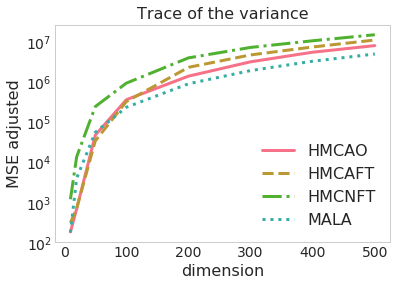

In [11]:
#linestyles = ['-', '--', '-', '--', '-.', ':']
for i, style in enumerate(names_prop):
    plt.plot(dim_list, (trace_var_particles.mean(axis=0)*computational_load.mean(axis=0)).transpose()[:,i], linestyle=linestyles[i], linewidth=3)
plt.ylabel('MSE adjusted', fontsize=16); plt.xlabel('dimension', fontsize=16)
plt.title('Trace of the variance', fontsize=16)
plt.legend(names_prop, fontsize=16, loc=0)
plt.yscale('log')
plt.savefig('normal_mse_var_comp_over_dim.pdf')
plt.show()

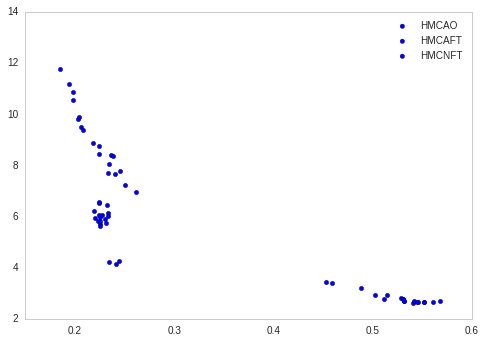

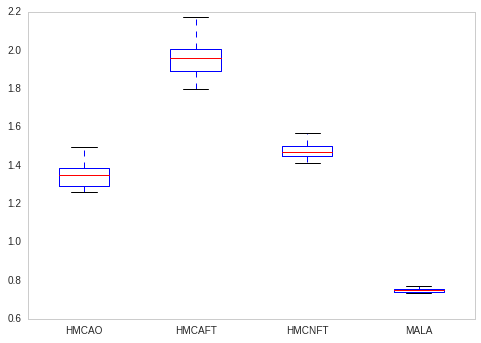

In [83]:
i_dim = 3
for i in range(3):
    plt.scatter(x=epsilon_array[:,i,i_dim], y=L_array[:,i,i_dim], label=names_prop[i])
    #plt.scatter(x=epsilon_array[:,1,0], y=L_array[:,1,0]); 
plt.legend()
plt.show()

plt.boxplot(epsilon_array[:,:,i_dim]*L_array[:,:,i_dim], labels=names_prop)
#plt.scatter(x=epsilon_array[:,1,0], y=L_array[:,1,0]); 
plt.legend()
plt.show()
